<a href="https://colab.research.google.com/github/theindianwriter/cs6910_assignment1/blob/main/DL_Assigment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from scipy.special import expit
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error

In [5]:
from keras.datasets import fashion_mnist

In [6]:
!pip install wandb -qqq
import wandb
wandb.login()

wandb: Currently logged in as: theindianwriter (use `wandb login --relogin` to force relogin)


True

In [7]:
def data_loader():
  (x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()
  num_of_train_data = x_train.shape[0]
  combined_training_data = list(zip(x_train,y_train))
  np.random.shuffle(combined_training_data)
  (x_train,y_train) = zip(*combined_training_data)
  x_train,y_train = np.array(x_train),np.array(y_train)
  validation_size = int(0.1*num_of_train_data)
  x_validation = x_train[:validation_size]
  y_validation = y_train[:validation_size]
  x_train = x_train[validation_size:]
  y_train = y_train[validation_size:]
  return x_train,y_train,x_validation,y_validation,x_test,y_test


In [8]:
x_train,y_train,x_validation,y_validation,x_test,y_test = data_loader()
print("information regarding the training,validation and test dataset")
print("the size of training dataset is {},validation set is {},test set is {}".format(x_train.shape[0],x_validation.shape[0],x_test.shape[0]))

information regarding the training,validation and test dataset
the size of training dataset is 54000,validation set is 6000,test set is 10000


In [9]:
def vectorize(Y):
  Y_vectorize = np.zeros((Y.shape[0],10))
  for i in range(Y.shape[0]):
      Y_vectorize[i][Y[i]] = 1.0
  return Y_vectorize

In [10]:
def prep_data(X,Y):
    X_vector = np.array([np.reshape(x,(784))for x in X])
    mean = np.mean(X_vector,axis = 0)
    std = np.std(X_vector,axis = 0)
    X_norm_vector = (X_vector - mean)/(std + 0.0001)
    Y_vectorize = vectorize(Y)
    return X_norm_vector,Y_vectorize

In [11]:
class_label = ['T-shirt/top', 
           'Trousers', 
           'Pullover', 
           'Dress', 'Coat', 
           'Sandal', 
           'Shirt', 
           'Sneaker', 
           'Bag', 
           'Ankle boot']

In [12]:
#Q1 plots one image of each class 

def plot_each_label(X,Y):
  rows = 2
  cols = 5
  fig = plt.figure()
  ax = []
  j = 0
  for i in range(1,rows*cols + 1):
    ax.append(fig.add_subplot(rows,cols,i))
    pos = np.where(Y == j)
    plt.imshow(X[pos[0][0]])
    plt.xticks([])
    plt.yticks([])
    ax[-1].set_title(class_label[j])
    j += 1
  plt.show()


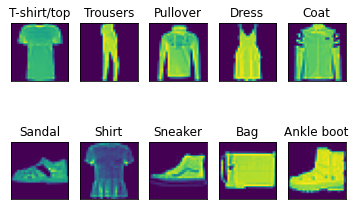

In [ ]:
#Q1 calls and plots image of each class
plot_each_label(x_train,y_train)

In [13]:
def softmax(X):
    output = np.zeros(X.shape)
    for col in range(X.shape[1]):
        exps = np.exp(X[:,col] - np.max(X[:,col]))
        output[:,col] = exps/exps.sum()

    return output

def sigmoid(X):
    return expit(X) #to avoid overflow

def sigmoid_derivative(x):
  return sigmoid(x)*(1-sigmoid(x))

def tanh(X):
    return np.tanh(X)

def relu(X):
    return np.maximum(X,0)

def tanh_derivative(X):
    return (1-np.square(tanh(X)))

def relu_derivative(X):
    return (X > 0)*(np.ones(np.shape(X))) + (X < 0 )*(0.01*np.ones(np.shape(X)))

  

In [14]:
class Network:

# ---------------------------------------START OF NETWORK INITIALIAZATION ---------------------------------------------
#----------------------------------------------------------------------------------------------------------------------
  #initialization of the network
  def __init__(self,layers,weight_initilizer = "random"):
    print(layers)
    self.num_of_layers = len(layers)
    self.layers = layers
    self.num_of_steps = 0

    #based on the methods the initilization would be done
    if weight_initilizer == 'random':
      self.random(layers)
    elif weight_initilizer == 'Xavier':
      self.Xavier(layers)
    else:
      print("ERROR")

    #used for mpmentum based gradient descent,adam and nadam
    self.prev_update_biases = [np.zeros((x,1)) for x in layers[1:]]
    self.prev_update_weights = [np.zeros((x,y)) for x,y in zip(layers[1:],layers[:-1])]
    #used for adam,rmsprop and nadam
    self.v_w = [np.zeros((x,y)) for x,y in zip(layers[1:],layers[:-1])]
    self.v_b = [np.zeros((x,1)) for x in layers[1:]]

#--------------------------------------END OF INITIALIZATION OF NETWORK------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

#-----------------------------------------START OF INITILIZATION OF WEIGHTS AND BIASES METHODS ------------------------------
#---------------------------------------------------------------------------------------------------------------------------

  def random(self,layers):
    self.biases = [np.random.randn(x,1) for x in layers[1:]]
    self.weights = [np.random.randn(x,y) for x,y in zip(layers[1:],layers[:-1])]

  def Xavier(self,layers):
    self.biases = [np.zeros((x,1)) for x in layers[1:]]
    self.weights = [np.random.randn(x,y)*2/np.sqrt(y+x) for x,y in zip(layers[1:],layers[:-1])]

#-------------------------------------------END OF INITIALIZATION OF WEIGHTS AND BIASES METHOD-------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------START OF CALCULATING LOSS FUNCTIONS ----------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------

  def calculate_loss(self,Y,Y_predicted):
    if self.loss == "cross_entropy_loss":
        error = log_loss(Y,Y_predicted)
        return error
    elif self.loss == "squared-error":
        error = mean_squared_error(Y,Y_predicted)
        return error
#--------------------------------------------------END OF CALCULATING LOSS FUNCTIONS------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------------

#-----------------------------------------------------------START OF ACTIVATION FUNCTION METHODS ----------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------------

  def perform_activation(self,A):
 
    if self.activation == 'sigmoid':
      return sigmoid(A)
    elif self.activation == "tanh":
      return tanh(A)
    elif self.activation == "relu":
        return relu(A)
    else:
      print("ERROR")

  def perform_output_function(self,A):

    if self.output_function == "softmax":
      H = softmax(A)
    else:
      print("ERROR")
    return H
#--------------------------------------------------END OF ACTIVATION FUNCTION METHODS-----------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------



  def update_parameter(self,grad_wrt_weights,grad_wrt_biases,eta,gamma = 0.5,beta1 = 0.9,beta2 = 0.999,eps = 1e-08):
    if self.optimizer == "sgd":
        update_wrt_biases = [eta*gb for gb in grad_wrt_biases]
        update_wrt_weights = [eta*gw for gw in grad_wrt_weights]

    elif self.optimizer == "momentum":
        update_wrt_biases = [gamma*ub + eta*gb for ub,gb in zip(self.prev_update_biases,grad_wrt_biases)]
        update_wrt_weights = [gamma*uw + eta*gw for uw,gw in zip(self.prev_update_weights,grad_wrt_weights)]

        self.prev_update_biases = update_wrt_biases
        self.prev_update_weights = update_wrt_weights

    elif self.optimizer == "nesterov":

        update_wrt_biases = [gamma*ub + eta*gb for ub,gb in zip(self.prev_update_biases,grad_wrt_biases)]
        update_wrt_weights = [gamma*uw + eta*gw for uw,gw in zip(self.prev_update_weights,grad_wrt_weights)]

        self.prev_update_biases = update_wrt_biases
        self.prev_update_weights = update_wrt_weights

    elif self.optimizer == "rmsprop":

        self.v_b = [beta2*t + (1-beta2)*(np.power(gb,2)) for t,gb in zip(self.v_b,grad_wrt_biases)]
        self.v_w = [beta2*t + (1-beta2)*(np.power(gw,2)) for t,gw in zip(self.v_w,grad_wrt_weights)] 
        

        update_wrt_biases = [(eta/np.power(vb+eps,0.5))*gb for vb,gb in zip(self.v_b,grad_wrt_biases)]
        update_wrt_weights = [(eta/np.power(vw+eps,0.5))*gw for vw,gw in zip(self.v_w,grad_wrt_weights)]


    elif self.optimizer == "adam":
        i = self.num_of_steps

        m_b =  [(beta1*mb + (1-beta1)*gb)for mb,gb in zip(self.prev_update_biases,grad_wrt_biases)] 
        m_w = [(beta1*mw + (1-beta1)*gw) for mw,gw in zip(self.prev_update_weights,grad_wrt_weights)] 

        m_b_hat = [mb*(1-np.power(beta1,i)) for mb in m_b]
        m_w_hat = [mw*(1-np.power(beta1,i)) for mw in m_w]

        self.v_w = [(beta2*vw + (1-beta2)*(np.power(gw,2))) for vw,gw in zip(self.v_w,grad_wrt_weights)] 
        self.v_b = [(beta2*vb + (1-beta2)*(np.power(gb,2))) for vb,gb in zip(self.v_b,grad_wrt_biases)]

        v_b_hat = [(vb/np.power(beta2,i)) for vb in self.v_b]
        v_w_hat = [(vw/np.power(beta2,i)) for vw in self.v_w]

        update_wrt_biases = [(eta/np.power(vb+eps,0.5))*mb for vb,mb in zip(v_b_hat,m_b_hat)]
        update_wrt_weights = [(eta/np.power(vw+eps,0.5))*mw for vw,mw in zip(v_w_hat,m_w_hat)]

        self.prev_update_biases = m_b
        self.prev_update_weights = m_w

    elif self.optimizer == "nadam":
        i = self.num_of_steps

        m_b =  [(beta1*mb + (1-beta1)*gb)for mb,gb in zip(self.prev_update_biases,grad_wrt_biases)] 
        m_w = [(beta1*mw + (1-beta1)*gw) for mw,gw in zip(self.prev_update_weights,grad_wrt_weights)] 

        m_b_hat = [mb*(1-np.power(beta1,i)) for mb in m_b]
        m_w_hat = [mw*(1-np.power(beta1,i)) for mw in m_w]

        self.v_w = [(beta2*vw + (1-beta2)*(np.power(gw,2))) for vw,gw in zip(self.v_w,grad_wrt_weights)] 
        self.v_b = [(beta2*vb + (1-beta2)*(np.power(gb,2))) for vb,gb in zip(self.v_b,grad_wrt_biases)]

        v_b_hat = [(vb/np.power(beta2,i)) for vb in self.v_b]
        v_w_hat = [(vw/np.power(beta2,i)) for vw in self.v_w]

        update_wrt_biases = [(eta/np.power(vb+eps,0.5))*mb for vb,mb in zip(v_b_hat,m_b_hat)]
        update_wrt_weights = [(eta/np.power(vw+eps,0.5))*mw for vw,mw in zip(v_w_hat,m_w_hat)]

        self.prev_update_biases = m_b
        self.prev_update_weights = m_w
        

    #updation of the parameters
    self.weights = [w - grad_w for w,grad_w in zip(self.weights,update_wrt_weights)]
    self.biases = [b - grad_b for b,grad_b in zip(self.biases,update_wrt_biases)]


    


  def forward_propagation(self,X):
    #input vector to the network
    A_h = X.T
    #array to store pre-activation vectors of the hidden layers and output layer
    A = []
    #array to store post activation vectors of the input layer,hidden layers and ouput layer
    H = [X.T]
    for w,b in zip(self.weights[:-1],self.biases[:-1]):
      A_h = np.matmul(w,A_h)+ b
      A.append(A_h)
      H_i = self.perform_activation(A_h)
      H.append(H_i)

    #calculating the pre-activation and post-activation vector in the output layer
    w,b = self.weights[-1],self.biases[-1]
    A_o = np.matmul(w,A[-1]) + b
    A.append(A_o)
    H_o = self.perform_output_function(A_o)
    H.append(H_o)
    return A,H,H[-1]


  def get_delta_hidden_layer(self,grad_wrt_weight,delta,A):
        if self.activation == "sigmoid":
            return np.matmul(grad_wrt_weight.T,delta)*(sigmoid_derivative(A))
        elif self.activation == "tanh":
            return np.matmul(grad_wrt_weight.T,delta)*(tanh_derivative(A))
        elif self.activation == "relu":
            return np.matmul(grad_wrt_weight.T,delta)*(relu_derivative(A))

  def get_delta_last_layer(self,A,H,Y):

    if self.loss == "cross_entropy_loss":
      delta = H - Y.T
      return delta
    elif self.loss == "squared-error":
      delta = (H - Y.T)*H*(1-H)
      return delta

  def backward_propagation(self,X,Y,A,H):
    grad_wrt_weights = [np.zeros(w.shape) for w in self.weights]
    grad_wrt_biases = [np.zeros(b.shape) for b in self.biases]
    N = X.shape[0]
    delta = self.get_delta_last_layer(A[-1],H[-1],Y)
    grad_wrt_biases[-1] = (1/N)*np.sum(delta,axis = 1,keepdims = True)
    grad_wrt_weights[-1] = (1/N)*np.matmul(delta,H[-2].T)
    for l in range(2,self.num_of_layers):
      delta = self.get_delta_hidden_layer(grad_wrt_weights[-l+1],delta,A[-l])
      grad_wrt_biases[-l] = (1/N)*np.sum(delta,axis = 1,keepdims = True)
      grad_wrt_weights[-l] = (1/N)*np.matmul(delta,H[-l-1].T)
      
    return grad_wrt_weights,grad_wrt_biases

  def fit(self,x_train,y_train,x_val,y_val,epochs = 5, eta = 0.001,gamma = 0.5,batch_size = 64,beta1 = 0.9):
      
    N = x_train.shape[0]
    prev_accuracy = 0
    max_accuracy = 0
    for epoch in range(1,epochs+1):
        batch_error = 0
        combined_training_data = list(zip(x_train,y_train))
        np.random.shuffle(combined_training_data)
        x_train[:],y_train[:] = zip(*combined_training_data)
        x_train,y_train = np.array(x_train),np.array(y_train)

        mini_x_batches = [x_train[i:i+batch_size] for i in range(0,N,batch_size)]
        mini_y_batches = [y_train[i:i+batch_size] for i in range(0,N,batch_size)] 

        for X,Y in zip(mini_x_batches,mini_y_batches):
            #only for nestorov accelerated gradient descent
            self.num_of_steps += 1
            if self.optimizer == "nesterov":
                self.biases = [b - gamma*ub for b,ub in zip(self.biases,self.prev_update_biases)]
                self.weights = [w - gamma*uw  for w,uw in zip(self.weights,self.prev_update_weights)]

            if self.optimizer == "nadam":
                self.biases = [b - beta1*ub*(1-np.power(beta1,self.num_of_steps)) for b,ub in zip(self.biases,self.prev_update_biases)]
                self.weights = [w - beta1*uw*(1-np.power(beta1,self.num_of_steps)) for w,uw in zip(self.weights,self.prev_update_weights)]

            #forward propagation
            A,H,Y_predicted = self.forward_propagation(X)
            #backward propagation
            grad_wrt_weights,grad_wrt_biases = self.backward_propagation(X,Y,A,H)
            #gradient descent variant
            self.update_parameter(grad_wrt_weights,grad_wrt_biases,eta,gamma)
            batch_error += self.calculate_loss(Y.T,Y_predicted)

        loss = batch_error/N
        accuracy_val = self.test(x_val,y_val)

        if(max_accuracy - accuracy_val) > 4.0:
            break

        max_accuracy = max(max_accuracy,accuracy_val)
        
        #for annealing the learning rate just a heuristic
        if (prev_accuracy - accuracy_val) > 0.5:
            eta = eta/2
        prev_accuracy = accuracy_val


        print("In epoch {} the loss for train set is {}".format(epoch,loss))
        print("In epoch {} the accuracy for validation set is {} %".format(epoch,accuracy_val))
        wandb.log({"epoch": epoch,"accuracy" : accuracy_val,"training loss":loss })
        print("---------------------------------------------------------\n")
        

  def compile(self,optimizer = "sgd",loss = "squared-error",activation = "sigmoid",output_function = "softmax",metrics = "accuracy"):

    self.activation = activation
    self.output_function = output_function
    self.optimizer = optimizer
    self.loss = loss
    self.metrics = metrics


  def test(self,X,Y):
    if self.metrics == "accuracy":
        A,H,Y_predicted = self.forward_propagation(X)
        Y_list = np.argmax(Y.T,axis = 0).reshape(Y.T.shape[1], 1)
        Y_list_predicted = np.argmax(Y_predicted,axis = 0).reshape(Y.T.shape[1], 1)
        accuracy_matrix = Y_list_predicted == Y_list
        accuracy_list = list(accuracy_matrix)
        correct = accuracy_list.count([True])
        return round(((correct*100)/len(accuracy_list)),2)



In [15]:
x_train_transformed,y_train_transformed = prep_data(x_train,y_train)

In [16]:
x_val_transformed,y_val_transformed = prep_data(x_validation,y_validation)

In [17]:
x_test_transformed,y_test_transformed = prep_data(x_test,y_test)

In [286]:
defaults = dict(
    num_of_hidden_layers = 3,
    size_of_hidden_layer = 64,
    optimizer = "momentum",
    loss = "squared-error",
    activation = "tanh",
    output_function = "softmax",
    metrics = "accuracy",
    learning_rate = 0.001,
    gamma = 0.5,
    epochs = 20,
    batch_size = 64,
    weight_initializer = "Xavier"
)

In [288]:
wandb.init(project="CS6910-assignment1",config = defaults)
config = wandb.config

epoch,11
accuracy,70.8
training loss,0.00049
_runtime,252
_timestamp,1615621664
_step,10


epoch,▁▂▂▃▄▅▅▆▇▇█
accuracy,▁▅▇█████▇▇▇
training loss,█▃▂▂▁▁▁▁▁▁▁
_runtime,▁▂▂▃▄▅▅▆▇▇█
_timestamp,▁▂▂▃▄▅▅▆▇▇█
_step,▁▂▂▃▄▅▅▆▇▇█


In [289]:
layers = [784,10]
for i in range(config.num_of_hidden_layers):
    layers.insert(1,config.size_of_hidden_layer)

In [290]:
net = Network(layers,weight_initilizer=config.weight_initializer)
net.compile(optimizer = config.optimizer,loss = config.loss,activation = config.activation,output_function = config.output_function,metrics = config.metrics)

[784, 64, 64, 64, 10]


In [291]:
net.fit(x_train_transformed,y_train_transformed,x_val_transformed,y_val_transformed,epochs = config.epochs, eta = config.learning_rate,batch_size = config.batch_size,gamma = config.gamma)

In epoch 1 the loss for train set is 0.0025054688515834668
In epoch 1 the accuracy for validation set is 7.5 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.002443507667615493
In epoch 2 the accuracy for validation set is 8.5 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.0023705509779455764
In epoch 3 the accuracy for validation set is 9.38 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.002299038805301475
In epoch 4 the accuracy for validation set is 10.3 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.002233979176013358
In epoch 5 the accuracy for validation set is 11.73 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.0021770750704946168
In epoch 6 the accuracy for validation set is 12.85 %
------------------------------------

In [25]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [5, 10, 20]
        },
        'learning_rate': {
            'values': [1e-2, 1e-3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd', 'rmsprop',"nesterov","momentum"]
        },
        'activation': {
            'values': ['tanh', 'sigmoid']
        },
        'num_of_hidden_layers': {
            'values' : [1,2]
        },
        'size_of_hidden_layer' : {
            'values' : [128,200]
        },
        'output_function':{
            'values': ["softmax"]
        },
        'batch_size':{
            'values': [16,32,64]
        },
        'weight_initializer': {
            'values': ["random",'Xavier']
        },
        'loss':{
            'values' : ["cross_entropy_loss"]
        },
        'gamma':{
            'values' : [0.5,0.9,0.6]
        },

    }
}

In [19]:
def train():
    defaults = dict(
    num_of_hidden_layers = 1,
    size_of_hidden_layer = 32,
    optimizer = "adam",
    loss = "cross_entropy_loss",
    activation = "tanh",
    output_function = "softmax",
    metrics = "accuracy",
    learning_rate = 0.001,
    gamma = 0.9,
    epochs = 20,
    batch_size = 64,
    weight_initializer = "Xavier"
    )

    wandb.init(project="CS6910-assignment1",config = defaults)
    config = wandb.config

    layers = [784,10]
    for i in range(config.num_of_hidden_layers):
        layers.insert(1,config.size_of_hidden_layer)

    net = Network(layers,weight_initilizer=config.weight_initializer)
    net.compile(optimizer = config.optimizer,loss = config.loss,activation = config.activation,output_function = config.output_function,metrics = config.metrics)

    net.fit(x_train_transformed,y_train_transformed,x_val_transformed,y_val_transformed,epochs = config.epochs, eta = config.learning_rate,batch_size = config.batch_size,gamma = config.gamma)


In [26]:
sweep_id = wandb.sweep(sweep_config, entity="theindianwriter", project="CS6910-assignment1")

Create sweep with ID: 8lsys0ks
Sweep URL: https://wandb.ai/theindianwriter/CS6910-assignment1/sweeps/8lsys0ks


In [29]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: inapqlvw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.9
wandb: 	learning_rate: 0.01
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 1
wandb: 	optimizer: rmsprop
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 200
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 200, 10]
In epoch 1 the loss for train set is 1.1492124802949835
In epoch 1 the accuracy for validation set is 71.4 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.9812269328077748
In epoch 2 the accuracy for validation set is 73.48 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.9551868746973023
In epoch 3 the accuracy for validation set is 72.27 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.8394056965645427
In epoch 4 the accuracy for validation set is 73.9 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.8383396641503048
In epoch 5 the accuracy for validation set is 72.33 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.7950030001015489
In epoch 6 the accuracy for validation set is 74.27 %
--------------------------------

epoch,20
accuracy,72.32
training loss,0.71917
_runtime,628
_timestamp,1615632553
_step,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
accuracy,▁▆▃▇▃█▆▄▆▆▅▄▄▅▅▄▄▃▃▃
training loss,█▅▅▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


Exception in thread Thread-83:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/internal/internal_api.py", line 1313, in agent_heartbeat
    timeout=60,
  File "/usr/local/lib/python3.7/dist-packages/wandb/old/retry.py", line 96, in __call__
    result = self._call_fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/internal/internal_api.py", line 123, in execute
    return self.client.execute(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/client.py", line 52, in execute
    result = self._get_result(document, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/client.py", line 60, in _get_result
    return self.transport.execute(document, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/transport/requests.py", line 38, in execute
    request = requests.post(self.url, **post_args)
  File "/usr/lo